In [190]:
import random
import matplotlib.pyplot as plt
import numpy as np

num_villes = 100
num_clients = num_villes - 1  # Exclure le dépôt

def generate_weighted_adjacency_matrix(n):
    adjacency_matrix = np.random.rand(n, n)  # Générer une matrice aléatoire entre 0 et 1
    adjacency_matrix *= 100  # Multiplier par une valeur maximale pour représenter les poids des distances
    adjacency_matrix = np.round(adjacency_matrix).astype(int)  # Arrondir les valeurs et les convertir en entiers
    np.fill_diagonal(adjacency_matrix, 0)  # Remplir les diagonales avec des zéros pour représenter les distances de la ville à elle-même
    return adjacency_matrix

matrice = generate_weighted_adjacency_matrix(num_villes)
print(matrice)


[[ 0 17 95 ... 55 45 77]
 [27  0 74 ... 87 68 65]
 [48  9  0 ... 16 86 24]
 ...
 [46 22 85 ...  0 60 89]
 [29 15 14 ... 38  0 16]
 [30 46 78 ... 14 19  0]]


In [191]:
import random
import numpy as np
from numpy.random import choice as np_choice

# Évaluer la qualité des solutions
def calculer_distance_total(solution, matrice):
    distances = matrice[solution[:-1], solution[1:]]
    return np.sum(distances)

def maj_pheromone(matrice_pheromone, routes, distances):
    evaporation = 0.5

    # Évaporation des phéromones   
    matrice_pheromone *= (1 - evaporation)

    # Dépôt de phéromones sur les meilleures routes
    for route, distance in zip(routes, distances):
        pheromones = Q / distance
        matrice_pheromone[route[:-1], route[1:]] += pheromones

def maj_pheromone_intensification(matrice_pheromone, routes_visitees, intensite):
    for route in routes_visitees:
        for i in range(len(route) - 1):
            ville_actuelle = route[i]
            ville_suivante = route[i + 1]
            matrice_pheromone[ville_actuelle, ville_suivante] += intensite

def selectionner_ville(matrice_pheromone, current_ville, ville_non_visitee, alpha, beta):

    pheromone = matrice_pheromone[current_ville, ville_non_visitee]
    
    distance = matrice[current_ville, ville_non_visitee]

    proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)

    proba[distance == 0] = 0  # Gérer les distances nulles
    
    total_proba = np.sum(proba)
    if total_proba == 0:
        proba = np.ones(len(proba)) / len(proba)
    else:
        proba /= total_proba

    proba = np.maximum(proba, 0)

    next_ville_index = np_choice(len(ville_non_visitee), p=proba)
    next_ville = ville_non_visitee[next_ville_index]

    return next_ville


def vrp(matrice, num_fourmis, num_iterations, alpha, beta):
    num_ville = len(matrice)
    matrice_pheromone = np.ones((num_ville, num_ville))  # Matrice des phéromones
    best_route = None
    best_distance = float('inf')

    for i in range(num_iterations):
        routes_visitees = []  # Routes visitées par les fourmis
        routes = []
        distances = []

        for j in range(num_fourmis):
            route = [0]  # Dépôt initial
            ville_non_visitees = np.arange(1, num_ville)  # Villes non visitées
            while ville_non_visitees.size > 0:
                current_ville = route[-1]
                next_ville = selectionner_ville(matrice_pheromone, current_ville, ville_non_visitees, alpha, beta)
                route.append(next_ville)
                ville_non_visitees = np.delete(ville_non_visitees, np.where(ville_non_visitees == next_ville))

            route.append(0)  # Retour au dépôt

            if ville_non_visitees.size == 0 and route[-1] == 0:
                distance = calculer_distance_total(route, matrice)
                routes.append(route)
                distances.append(distance)

                if distance < best_distance:
                    best_route = route
                    best_distance = distance

                routes_visitees.append(route)

        maj_pheromone(matrice_pheromone, routes, distances)
        maj_pheromone_intensification(matrice_pheromone, routes_visitees, intensite)  # Intensification de la matrice de phéromone


    return best_route, best_distance


# On répartit entre le nombre de camions
def repartir_routes_optimal(route, num_camions):
    villes = route[1:-1]  # Liste des villes à répartir (excluant le dépôt)
    num_villes = len(villes)

    # Calcul de la distance totale de la route
    distance_totale = calculer_distance_total(route, matrice)

    # Calcul de la distance moyenne par camion
    distance_moyenne = distance_totale / num_camions

    camions_routes = []
    longueurs_routes = []

    camion_route = [0]  # Dépôt initial
    longueur_route = 0

    for i in range(num_villes):
        ville = villes[i]
        ville_suivante = villes[i + 1] if i < num_villes - 1 else 0  # Prochaine ville ou retour au dépôt

        # Ajout de la ville à la route actuelle
        camion_route.append(ville)
        longueur_route += matrice[ville][ville_suivante]

        # Si la longueur de la route actuelle dépasse la distance moyenne, on la termine et on commence une nouvelle route
        if longueur_route > distance_moyenne:
            camion_route.append(0)  # Retour au dépôt
            camions_routes.append(camion_route)
            longueurs_routes.append(longueur_route)

            camion_route = [0]  # Nouvelle route avec le dépôt initial
            longueur_route = 0

    # Ajout de la dernière route incomplète
    camion_route.append(0)  # Retour au dépôt
    camions_routes.append(camion_route)
    longueurs_routes.append(longueur_route)

    return camions_routes, longueurs_routes

# Paramètres de l'ACO
num_fourmis = 3
num_iterations = 15
alpha = 1.0  # Influence de la phéromone
beta = 5.0  # Influence de la visibilité   
Q = 100  # Quantité de phéromone déposée par les fourmis
intensite = 1.7 #intensification des pheromones
num_camions = 3  # Quantité de camions

best_route, best_distance = vrp(matrice, num_fourmis, num_iterations, alpha, beta)
camions_routes, longueurs_routes = repartir_routes_optimal(best_route, num_camions)

print("|-----------------Meilleur Global-----------------|")
print("Meilleure route:", best_route)
print("Distance totale:", best_distance)
print("|---------------Meilleur par camion---------------|")

# Affichage des routes assignées à chaque camion et de la longueur totale de chaque route
for i, route in enumerate(camions_routes):
    print(f"|------------------------{i+1}-----------------------|")
    print(f"Camion {i+1} - Route : {route} ")
    print(f"Distance totale : {longueurs_routes[i]}")
    

C:\Users\Theo\AppData\Local\Temp\ipykernel_9360\1275703547.py:34: RuntimeWarning: divide by zero encountered in divide
  proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)


|-----------------Meilleur Global-----------------|
Meilleure route: [0, 16, 77, 37, 61, 26, 79, 32, 56, 43, 90, 44, 45, 28, 81, 78, 22, 1, 94, 72, 25, 83, 11, 89, 57, 60, 20, 5, 3, 96, 93, 67, 17, 99, 12, 15, 58, 36, 6, 66, 46, 91, 19, 42, 52, 50, 33, 41, 64, 88, 24, 82, 21, 49, 80, 85, 63, 51, 95, 98, 13, 18, 69, 39, 70, 29, 2, 14, 8, 73, 68, 34, 87, 55, 47, 59, 54, 30, 71, 86, 10, 31, 23, 92, 4, 84, 7, 48, 38, 97, 27, 76, 40, 74, 62, 65, 75, 53, 9, 35, 0]
Distance totale: 352
|---------------Meilleur par camion---------------|
|------------------------1-----------------------|
Camion 1 - Route : [0, 16, 77, 37, 61, 26, 79, 32, 56, 43, 90, 44, 45, 28, 81, 78, 22, 1, 94, 72, 25, 83, 11, 89, 57, 60, 20, 5, 3, 96, 93, 67, 17, 99, 12, 15, 58, 36, 6, 66, 46, 91, 19, 42, 52, 50, 33, 41, 64, 88, 24, 82, 21, 49, 80, 85, 63, 51, 95, 98, 13, 18, 69, 39, 70, 29, 2, 14, 0] 
Distance totale : 118
|------------------------2-----------------------|
Camion 2 - Route : [0, 8, 73, 68, 34, 87, 55, 47, 

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: list index out of range

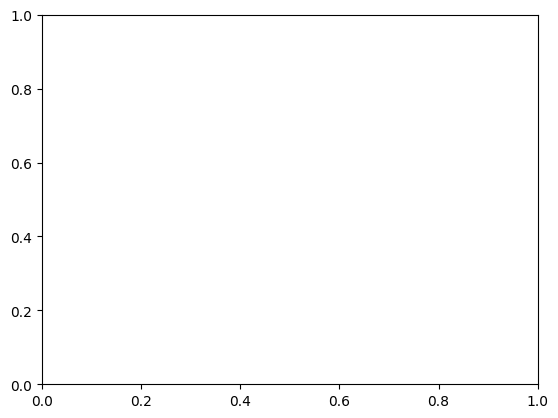

In [196]:
from sklearn.cluster import KMeans
import numpy as np

def generer_coordonnees_clusters(nb_points, nb_clusters):
    # Générer des coordonnées aléatoires pour les centres de clusters
    np.random.seed(0)
    cluster_centers = np.random.uniform(0, 100, size=(nb_clusters, 2))

    # Générer des points en utilisant l'algorithme K-means
    kmeans = KMeans(n_clusters=nb_clusters, random_state=0).fit(cluster_centers)
    labels = kmeans.labels_

    coord_x = []
    coord_y = []

    for label in set(labels):
        indices = np.where(labels == label)[0]
        cluster_points = cluster_centers[label] + np.random.normal(0, 2, size=(len(indices), 2))
        coord_x.extend(cluster_points[:, 0])
        coord_y.extend(cluster_points[:, 1])

    return coord_x, coord_y

# Utilisation
coord_x, coord_y = generer_coordonnees_clusters(100, 3)




def tracer_routes(routes):
    fig, ax = plt.subplots()
    couleurs = ['r', 'g', 'b', 'c', 'm', 'y']  # Couleurs pour chaque camion
    labels = []

    for i, route in enumerate(routes):
        x = []
        y = []

        for ville in route:
            x.append(coord_x[ville])
            y.append(coord_y[ville])

        x.append(coord_x[route[0]])  # Ajouter le dépôt initial pour fermer la boucle
        y.append(coord_y[route[0]])

        ax.plot(x, y, '-o', color=couleurs[i % len(couleurs)])  # Tracer la route du camion
        labels.append(f'Camion {i+1}')

    ax.legend(labels)
    ax.set_xlabel('Coordonnée X')
    ax.set_ylabel('Coordonnée Y')
    plt.show()

# Utilisation
tracer_routes(camions_routes)
